# Classes and variables

In [38]:
import librosa
from sklearn.preprocessing import LabelEncoder
from birdclassification.preprocessing.filtering import filter_recordings_30
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
import torchaudio
import random
from birdclassification.preprocessing.augmentations_wrappers import InvertPolarity, AddWhiteNoise, PitchShifting, RandomGain, TimeShift, RandomChunk
from birdclassification.preprocessing.spectrogram import generate_mel_spectrogram
from birdclassification.preprocessing.utils import get_loudest_index, cut_around_index
from birdclassification.visualization.plots import plot_torch_spectrogram

In [39]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
    
SEED = 123
RECORDINGS_DIR = '/media/jacek/E753-A120/recordings_30/'
SAMPLE_RATE = 32000
NUM_SAMPLES = SAMPLE_RATE * 1
BATCH_SIZE = 64
random.seed(SEED)

In [40]:
class AugmentationsPipeline(torch.nn.Module):
    def __init__(self, target_sr = 32000, n_fft = 512, hop_length = 3 * 128, sample_length = 3, number_of_bands = 64, fmin = 150, fmax = 15000):
        super().__init__()
        self.target_sr = target_sr
        # self.augmentations = [InvertPolarity(), 
        #                       AddWhiteNoise(min_factor=0.1, max_factor=0.8), 
        #                       RandomGain(min_factor=0.5, max_factor=1.5), 
        #                       TimeShift(min_factor=0.1, max_factor=0.3), 
        #                       RandomChunk(sr = target_sr, min_factor=0.1 , max_factor=1), 
        #                       PitchShifting(sr = target_sr, min_semitones=1, max_semitones=10)]
        
        self.augmentations = []
        self.probabilities = [0.5 for i in range(len(self.augmentations))]
        # self.get_spectrogram = torchaudio.transforms.MelSpectrogram(
        #     sample_rate=SAMPLE_RATE,
        #     n_fft=1024,
        #     hop_length=512,
        #     n_mels=64
        # )
        self.get_spectrogram = generate_mel_spectrogram
        self.get_loudest_index = get_loudest_index
        self.cut_around_largest_index = cut_around_index
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.sample_length = sample_length
        self.number_of_bands = number_of_bands
        self.fmin = fmin
        self.fmax = fmax
        
        
    
    def forward(self, waveform: torch.Tensor) -> torch.Tensor: 
        #select loudest 3 second chunk
        peak = get_loudest_index(waveform, self.n_fft, self.hop_length)
        waveform = cut_around_index(waveform, peak, self.target_sr * self.sample_length)
        #augmentations
        #n = random.randint(0, len(self.augmentations))
        #selected = random.choices(list(self.augmentations), weights=self.probabilities, k=n)
        #print(selected)
        #aug = torch.nn.Sequential(*selected)
        #augmented = aug(waveform)
        waveform = self.mix_down_if_necessary(waveform)
        #generate spectrogram
        spectrogram = self.get_spectrogram(waveform, self.target_sr, self.n_fft, self.hop_length)
        
        return spectrogram
    
    def mix_down_if_necessary(self, audio):
        if audio.shape[0] > 1:
            audio = torch.mean(audio, dim = 0,  keepdim=True)
        return audio

In [41]:
class Recordings30(Dataset):
    def __init__(self,
                 df,
                 recording_dir,
                 transform=None,
                 sample_rate=32000,
                 device = "cpu"):
        
        df['filepath'] = df.apply(lambda x: f"{recording_dir}{x['Latin name']}/{str(x['id'])}.mp3" , axis=1)
        le = LabelEncoder()
        df['label'] = le.fit_transform(df['Latin name'])
        
        self.sample_rate = sample_rate
        self.filepath = df['filepath'].to_numpy()
        self.label = df['label'].to_numpy()
        self.device = device
        self.recording_dir = recording_dir
        self.augmentation_pipeline = AugmentationsPipeline()
        #self.transform = transform.to(self.device) 
        self.le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

    def __len__(self):
        return self.filepath.size

    def __getitem__(self, idx):
        audio, sr = torchaudio.load(self.filepath[idx])
        print(f"After load: {audio.shape}")
        
        #select fragment
        #audio = audio.to(self.device)
        label = self.label[idx]

        audio = self.augmentation_pipeline(audio)
        print(f"Shape after augmentation pipeline: {audio.shape}")

        # if self.transform:
        #     audio = self.transform(audio)
        return audio, label
    
    

# Prepare dataset and dataloaders

In [42]:
df = filter_recordings_30("../../data/xeno_canto_recordings.csv", "../../data/bird-list-extended.csv", )

train_df, test_val_df = train_test_split(df, stratify=df['Latin name'], test_size=0.2, random_state = SEED)
val_df, test_df = train_test_split(test_val_df, stratify=test_val_df['Latin name'], test_size=0.5, random_state = SEED)

train_ds = Recordings30(train_df, recording_dir=RECORDINGS_DIR, sample_rate=SAMPLE_RATE, device = DEVICE)
val_ds = Recordings30(val_df, recording_dir=RECORDINGS_DIR, device = DEVICE)
test_ds = Recordings30(test_df, recording_dir=RECORDINGS_DIR, device = DEVICE)

train_dl  = DataLoader(train_ds, batch_size= BATCH_SIZE)
val_dl  = DataLoader(val_ds, batch_size= BATCH_SIZE)
test_dl  = DataLoader(test_ds, batch_size= BATCH_SIZE)

/home/jacek/PycharmProjects/Bird-classification-model/birdclassification/preprocessing/filtering.py:45: DtypeWarning: Columns (10,39,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  recordings = pd.read_csv(filepath_recordings)


After load: torch.Size([2, 1412672])
Shape after augmentation pipeline: (64, 251)
0
(64, 251)


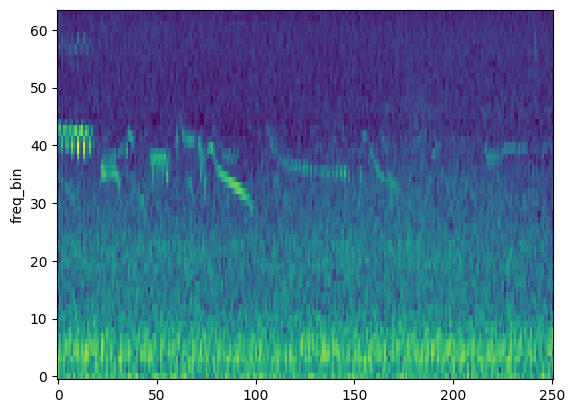

In [43]:
import librosa
audio, label = train_ds[13]
print(label)
print(audio.shape)
plot_torch_spectrogram(audio)

# Model

In [44]:
from torch import nn
from torchsummary import summary

In [47]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / liniear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(
            10880, 30 
        )
        self.softmax = nn.Softmax(dim = 1)
        
            
        
    def forward(self, input_data):
        print("input", input_data.shape)
        x = self.conv1(input_data)
        print("conv1", x.shape)
        x = self.conv2(x)
        print("conv2", x.shape)
        x = self.conv3(x)
        print("conv3", x.shape)
        x = self.conv4(x)
        print("conv4", x.shape)
        x = self.flatten(x)
        print("flatten", x.shape)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions 

In [48]:
cnn = CNNNetwork()
summary(cnn, (1, 64, 251)) 

input torch.Size([2, 1, 64, 251])
conv1 torch.Size([2, 16, 33, 126])
conv2 torch.Size([2, 32, 17, 64])
conv3 torch.Size([2, 64, 9, 33])
conv4 torch.Size([2, 128, 5, 17])
flatten torch.Size([2, 10880])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 66, 253]             160
              ReLU-2          [-1, 16, 66, 253]               0
         MaxPool2d-3          [-1, 16, 33, 126]               0
            Conv2d-4          [-1, 32, 35, 128]           4,640
              ReLU-5          [-1, 32, 35, 128]               0
         MaxPool2d-6           [-1, 32, 17, 64]               0
            Conv2d-7           [-1, 64, 19, 66]          18,496
              ReLU-8           [-1, 64, 19, 66]               0
         MaxPool2d-9            [-1, 64, 9, 33]               0
           Conv2d-10          [-1, 128, 11, 35]          73,856
             ReLU-11          

In [49]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
cnn = CNNNetwork().to(device)
device

'cpu'

In [50]:
def train_one_epoch(model, data_loader, loss_fn, optimiser, device):
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        #calculate loss
        predictions = model(inputs)
        loss = loss_fn(predictions, targets)

        #backpropagate loss and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"Loss {loss.item()}")


def train(model, data_loader, loss_fn, optimiser, device, epochs):
    for i in range(epochs):
        print(f"Epoch {i + 1}")
        train_one_epoch(model, data_loader, loss_fn, optimiser, device)
    print("Finished training")


def predict(model, input, target, class_mapping):
    model.eval()
    with torch.no_grad():
        predctions = model(input)
        predicted_index = predctions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected

In [51]:
EPOCHS = 1
LEARNING_RATE = 0.001
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(cnn.parameters(), LEARNING_RATE)
train(cnn, train_dl, loss_fn, optimiser, device, EPOCHS)

torch.save(cnn.state_dict(), "cnn.pth")

Epoch 1
After load: torch.Size([1, 422848])
Shape after augmentation pipeline: (64, 251)
After load: torch.Size([2, 448832])
Shape after augmentation pipeline: (64, 251)
After load: torch.Size([2, 2010432])
Shape after augmentation pipeline: (64, 251)
After load: torch.Size([1, 203840])
Shape after augmentation pipeline: (64, 251)
After load: torch.Size([2, 1416384])
Shape after augmentation pipeline: (64, 251)
After load: torch.Size([2, 5618624])
Shape after augmentation pipeline: (64, 251)
After load: torch.Size([1, 945856])
Shape after augmentation pipeline: (64, 251)
After load: torch.Size([2, 1409600])
Shape after augmentation pipeline: (64, 251)
After load: torch.Size([2, 3386944])
Shape after augmentation pipeline: (64, 251)
After load: torch.Size([1, 206912])
Shape after augmentation pipeline: (64, 251)
After load: torch.Size([2, 871232])
Shape after augmentation pipeline: (64, 251)
After load: torch.Size([2, 731200])
Shape after augmentation pipeline: (64, 251)


KeyboardInterrupt: 